In [47]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import plotly.express as px
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
import warnings
warnings.filterwarnings('ignore')
import pickle

# Load data and model

In [69]:
# PNLs in the data is calculated by forward looking 120 day
test_len = 60

In [31]:
# This is the output of the data processing for both option1 and 2
processed_data = pd.read_csv('../Outputs/data_pipeline_output.csv')

In [32]:
# model that predicts entry apperance
with open('../Outputs/entry_model_latest.pkl', 'rb') as file:
    entry_model = pickle.load(file)

In [33]:
# model that predicts exit appearce
with open('../Outputs/exit_model_latest.pkl', 'rb') as file:
    exit_model = pickle.load(file)

# Define the testing period

In training the models above, we used data up to 2021-8-10.

In [96]:
future_data = processed_data[processed_data.Date>'2021-08-10']

training_data = processed_data[processed_data.Date<='2021-08-10']

# Get SPY returns

In [97]:
spy_df = pd.read_csv('../Data/Training/1999-12-01-2023-12-31_SPY.csv')
spy_df = spy_df[['Date','Adj Close']]
spy_df.columns = ['Date','SPY_Close']

look_forward_d = test_len
# Define a variable to calculate the return if we just buy SPY and sell in the next 60 days
spy_return = []
for i in range(spy_df.shape[0]):
    if (i + look_forward_d) < spy_df.shape[0]:
        spy_return.append(
            (spy_df.loc[i+look_forward_d]['SPY_Close'] - spy_df.loc[i]['SPY_Close'])/spy_df.loc[i]['SPY_Close']
        )
    else:
        spy_return.append(
            np.nan
        )
spy_df['SPY_return'] = spy_return

In [98]:

# Predict entry apperances in the next 1-3 days
pred_entry = entry_model.predict(future_data[entry_model.feature_names.values])

# Predict exit appearance in the next 9-12 days
pred_exit = exit_model.predict(future_data[entry_model.feature_names.values])

future_data['entry_appears'] = pred_entry
future_data['exit_appears'] = pred_exit

# get the next 60d PNL from S&P
future_data = pd.merge(
    future_data, 
    spy_df, 
    how='left',
    left_on='Date',
    right_on='Date'
)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=196, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=196
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


# Strategy

1. The original option 2 trade strategy when executing pair trading (need to understand which parameters were used when generating data './pair_features_1_pairs500_300_120.csv')

2. Only spend on pair trading if:
    1. Entry and exit are both predicted to be 1
    2. cosine_sim > 0.8
  
3. We invest part of the money on S&P500 and part of the money on pair-trading. During the next 60 days, if a qualified stock pair does not have entry signal then we do not invest that part of the money
    1. For each qualified stock pair, we invest the same amount of money

In [224]:
qualified_pairs = future_data[
    (future_data.entry_appears == 1) & (future_data.exit_appears == 1) & (future_data.stock2vec_cos_sim>0.9)
]

In [225]:
pair_trading_return = qualified_pairs[['Date','pnls']].groupby('Date').mean().reset_index()
pair_trading_return.columns = ['Date', 'pair_trade_pnls']

In [226]:
future_data_spy = future_data[['Date','SPY_return']].drop_duplicates()

In [227]:
final_return = pd.merge(future_data_spy,pair_trading_return,how='left',on='Date')

In [228]:
final_return.pair_trade_pnls.fillna(0,inplace=True)

count   541.000
mean     -0.000
std       0.022
min      -0.061
25%      -0.017
50%      -0.004
75%       0.013
max       0.065
Name: delta, dtype: float64

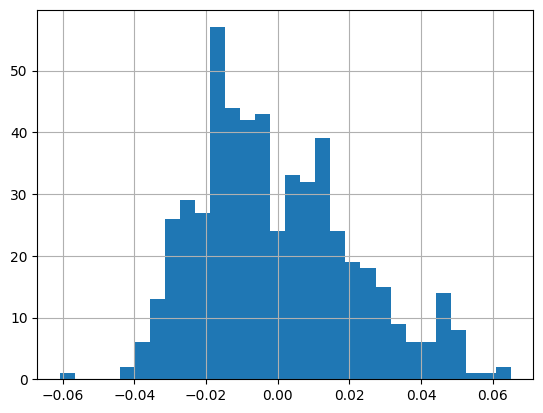

In [240]:
share_for_sp500 = 0.7
final_return['final_return'] = \
(share_for_sp500*final_return['SPY_return'] + (1-share_for_sp500)*final_return['pair_trade_pnls'])
final_return['delta'] = final_return.final_return - final_return['SPY_return']
final_return['delta'].hist(bins=30)
final_return['delta'].describe()

count   541.000
mean      0.006
std       0.055
min      -0.148
25%      -0.033
50%       0.014
75%       0.046
max       0.117
Name: final_return, dtype: float64

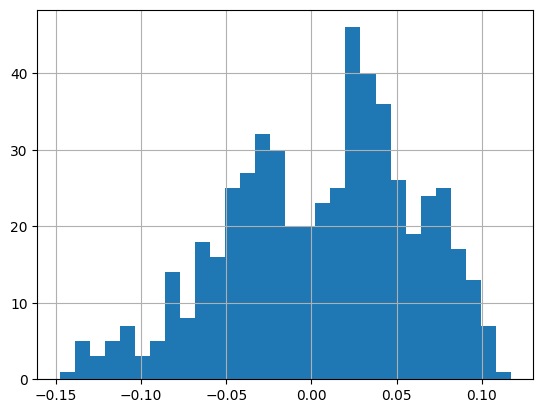

In [236]:
final_return['final_return'].hist(bins=30)
final_return['final_return'].describe()